In [1]:
import pandas as pd
import scipy
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime

# RQ7 #

## a) What's the probability that a post receives more than 20% "likes" of the number of followers a user has? ##

In [2]:
df_profiles = pd.read_csv(r"C:\Users\nicol\Desktop\esami_sapienza\adm\homework2/instagram_profiles.csv", delimiter = '\t')

In [3]:
df_locations = pd.read_csv(r"C:\Users\nicol\Desktop\esami_sapienza\adm\homework2/instagram_locations.csv", delimiter = '\t')

In [4]:
df_posts = pd.read_csv(r"C:\Users\nicol\Desktop\esami_sapienza\adm\homework2/instagram_posts.csv", delimiter = '\t', usecols = ['profile_id','numbr_likes', 'number_comments','cts','location_id']) 

In [5]:
data_profiles2 = df_profiles[['profile_id', 'followers']] # we selected only two columns from profiles that are profile_id
                                                            # and followers

In [6]:
data_profiles2 = data_profiles2.dropna(axis = 0, how = 'any') # we remove all the rows of the dataset that show a missing value
                                                              # of profile_id or followers

In [7]:
data_posts2 = df_posts[['profile_id', 'numbr_likes']]  # we selected only two columns from posts that are profile_id
                                                         # and numbr_likes

In [8]:
data_posts2 = data_posts2.dropna(axis = 0, how = 'any')  # we remove all the rows of the dataset that show a missing value
                                                         # of profile_id or numbr_likes

In [9]:
print(data_posts2.shape)
print(data_profiles2.shape)

(40126905, 2)
(3447698, 2)


In [10]:
merge = pd.merge(data_profiles2, data_posts2, on = "profile_id" )  # we do the merge between the two set on the variable profile_id
                                                                   # because we want to use only the profiles that have a match in both of dataset

We calculated the number of posts that receives more than 0.20 % likes of the number of followers and we divided it by the total number of posts to get the probability

In [11]:
count = 0 
n = merge.shape[0]
for row in range(n):
    count += np.sum(merge.numbr_likes[row] > 0.20*merge.followers[row])
prob = count/merge.shape[0]
print(prob)

0.15716325833178058


The probability is almost 0.1572 very low, but it makes sense because people, in general, have more followers than the number of likes of every post.

## b) Do users usually return to locations? Extract the probability that a user returns to a site after having posted it in the past. Does that probability make sense to you? Explain why or why not. ##

In [12]:
data_posts_loc = df_posts[['profile_id','location_id']].dropna(axis = 0, how = 'any')  
# we selected only two columns from posts that are profile_id
# and location_id

In [13]:
somma = np.sum((data_posts_loc.groupby(['profile_id','location_id']).size() > 1))
# we calculated the occurrences of location that are repeated more than one for every profile that means count 1 every time a 
# profile publishes a post in a previously posted location.

In [14]:
prob2 = somma/data_posts_loc.shape[0]
print(prob2)

0.10347941689544352


The probability is very low, it is almost 0.1035. I think that this probability doesn't make sense if we consider that a person, who inserted a location, wasn't necessarily in that location in reality. On instagram, people uses location also to obtain more visualizations and likes.

# RQ8 #



## a) Does more likes also mean more comments? ##

To see easily the relationship between likes and comments we compute two different sized random samples of data_posts to comply approximately the behaviour of the entire dataset. Obviously, bigger is the sample size, greater is the proximity to the entire dataset. To obtain a good visualization we use two reandom samples of size 50000 and 100000.

In [15]:
new_data = df_posts.sample(n = 50000, random_state = 10)
new_data2 = df_posts.sample(n = 100000, random_state = 10)

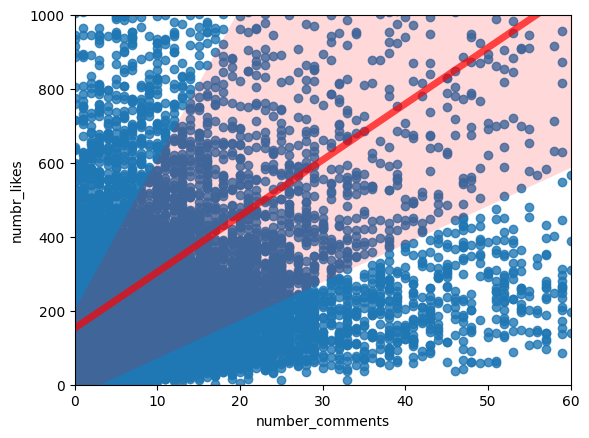

In [16]:
sns.regplot(x=new_data.number_comments, y=new_data.numbr_likes, line_kws={"color":"r","alpha":0.7,"lw":5})
plt.xlim(0,60)
plt.ylim(0,1000)
plt.show()

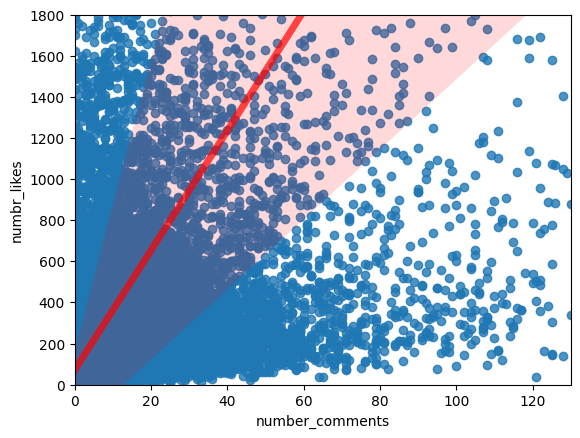

In [17]:
sns.regplot(x=new_data2.number_comments, y=new_data2.numbr_likes, line_kws={"color":"r","alpha":0.7,"lw":5})
plt.xlim(0,130)
plt.ylim(0,1800)
plt.show()

As said previously, to obtain a better visualization, we computed a random sample of size 10000 from the population. This sample must have the more or less the same characteristics of the total population. The scatterplot shows the relationship between the number of comments and the number of likes and, as can be seen, there is a positive relationship. To show the positive linear relationship even better, we have constructed a regression line. The line has a positive angular coefficient, which shows that as comments increase, on average, the number of likes also increases. We can also compute the index correlation to show numerically the intensity of this linear relationship, but we can do it directly on the entire dataset.


In [18]:
new_data.corr()

C:\Users\nicol\AppData\Local\Temp\ipykernel_25244\594412850.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  new_data.corr()


,profile_id,location_id,numbr_likes,number_comments
profile_id,1.000000,0.035482,-0.041830,-0.026470
location_id,0.035482,1.000000,0.008681,0.001180
numbr_likes,-0.041830,0.008681,1.000000,0.419304
number_comments,-0.026470,0.001180,0.419304,1.000000


This is the correlation matrix only for the columns of number of likes and number of comments. Correlation index measures the intensity of the lineare relationship and in this particular case there is a presence of a small positive linear relationship and it is equal to 0.374453. 

## b) Can you find any significant relationship between the time a user publishes a post and the number of comments and “likes”? Use an appropriate statistical test or technique and support your choice. ##

In [19]:
data_posts_cts = df_posts[['numbr_likes','number_comments','cts']].dropna(axis = 0, how = 'any')  # if there are missing values we are dropping rows that contain them

In [20]:
type(data_posts_cts.cts.values[0])   #the type of elements of cts column is string

str

In [21]:
def convert(date):
    if isinstance(date,str):
        return pd.Timestamp(date).hour     # we creted a function that convert the strings in pandas data type
                                           # and we extracted only the hours to compute summaries that male sense on the time

In [22]:
data_posts_cts['cts'] = data_posts_cts['cts'].apply(convert) # we apply the function on the entire column cts

Now, we want to make groups by hours and compute some statistic summaries of number of like and number of comment to understand the relationship of the time among these variables. 
First we calculate the average of likes and comments based on hours, so we can understand what is the best time to publish posts to get more likes or comments.

In [23]:
mean_data_sorted_likes = data_posts_cts.groupby('cts').mean().sort_values(['numbr_likes','number_comments'], ascending  = False)

In [24]:
mean_data_sorted_likes

,numbr_likes,number_comments
cts,,
18,308.104218,8.177722
16,303.836960,7.640960
12,302.702326,7.928864
19,299.029985,8.020855
13,295.834220,7.684591
14,295.613455,7.914549
17,294.936697,7.902970
15,291.164779,7.558913
20,289.023202,8.118177


We sorted the results by likes and comments and as shown the best time to publish a post is at 18 or 16. Usually the first hours of a post are the most important because in this time period the post has more visibility, for this reason it is relevant to follow this table.

In [25]:
mean_data_sorted_comments = data_posts_cts.groupby('cts').mean().sort_values(['number_comments','numbr_likes'], ascending  = False)

In [26]:
mean_data_sorted_comments

,numbr_likes,number_comments
cts,,
18,308.104218,8.177722
20,289.023202,8.118177
19,299.029985,8.020855
12,302.702326,7.928864
14,295.613455,7.914549
17,294.936697,7.902970
11,285.417389,7.773021
2,278.815356,7.772832
8,264.920865,7.710575


This time, we sorted the results by comments and then by likes and as shown the best time to publish a post is 18 too ( another confirm that it is the best time to publish a post) or 20. In both cases the worst hours to publish a post seems to be 5, 6 and 22.

## c) What’s the distribution of followers? Plot the empirical distribution of followers amongst all users and extract the mean, mode, and quantiles. Interpret those figures. ## 

(0.0, 1.5)

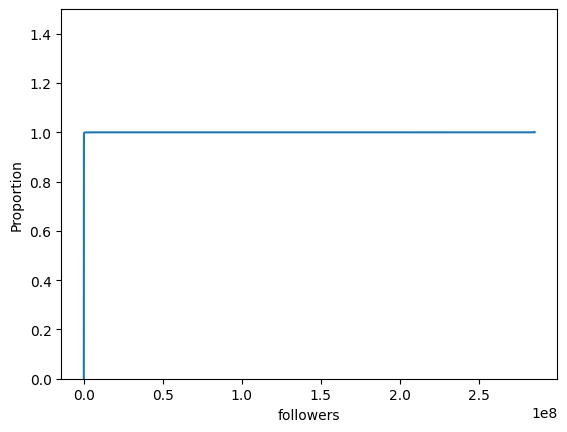

In [27]:
sns.ecdfplot(data_profiles2, 
             x="followers",)
plt.ylim(0,1.5)

This is the plot of the empirical distrubution of followers amongst all users. The fact that the probability 1 is reached "near" the value zero means that there are few values that are very big, most of the distribution doesn't have very high values of followers. We can also compute all the values of the cumulative distribution function with the following code.

In [28]:
import dc_stat_think as dcst
from statistics import mode

In [29]:
x, y = dcst.ecdf(data_profiles2.followers)

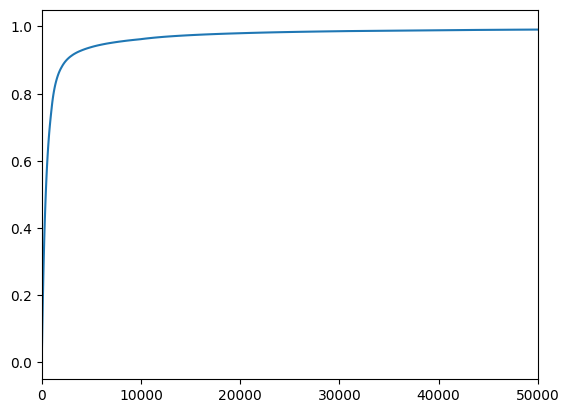

In [30]:
plt.plot(x,y)
plt.xlim(0,50000)
plt.show()


We have the same result, but now we have a more concentrated visualization to see the behaviour of the function for lower values. Furthermore, we can use the  calculated values to extract the mean, mode and quantiles.

In [31]:
average = np.mean(x)
print(average)


4745.391576350365


The mean of the followers of all users is about 4740. This value summarizes the entire distribution of followers with a single number representing the data’s center point or typical value.

In [32]:
median = np.min(x[y >= 0.5])
print(median)


406.0


The median is equal to 406.0. This value is the midpoint of the distribution and is the point at which half the observations are above the value and half the observations are below the value. The median and the mean both measure central tendency. But unusual values, called outliers, can affect the median less than they affect the mean. In this case the distribution is positevely asymmetric because the mean is greater than the median. This could suggest that there are very large values of followers that affect the average, perhaps possible outliers, but if we think about the nature of the dataset concerning instagram, they they could only be famous people with a lot of followers.

In [33]:
moda = mode(x)
print(moda)

0.0


The mode is 0.0, it the value that appears most frequently in a data set. This value makes it clear that there are a very high amount of profiles that have 0 followers. This low number could be due to the presence of many fake accounts or many bot accounts without followers.

In [34]:
first_quantile = np.min(x[y >= 0.25])
print(first_quantile)

second_quantile = median
print(second_quantile)

third_quantile = np.min(x[y >= 0.75])
print(third_quantile)

159.0
406.0
974.0


The quantiles, more precisely the quartiles have an interpretation similar to that of the median. In this case the first quartile is 159.0 and it means that the 25% of profiles on instagram have less than 159 followers.

The second quartile is equal to the median and it means that a 50% of the profiles have less than 406 followers, but also that the other 50% of the profiles have more than 406 followers.

The third quartile is 974.0 and it means that the 25% of profiles on instagram have more than 974.0 followers or the 75% of profiles on instagram have less than 974.0 followers.

Thanks to these quartiles we can see how the average ranks beyond the third quartile, precisely because there are very high values of followers that influence it.

## d) What are histograms, bar plots, scatterplots and pie charts used for? ##

All heard the old adage: “a picture is worth a thousand words”. One of the best techniques for understanding data is to visualize the numbers as a picture. This can make it far easier to see a pattern or it can expose patterns that might otherwise have been concealed. Data can be visualized in different ways, some charts are more appropriate than others, depending on the nature of the data. We focus on histograms, bar plots, scatterplots and pie charts. 

### HISTOGRAM ###

The histogram is used to summarize discrete or continuous data that are measured on an interval scale. It is often used to illustrate the major features of the distribution of the data in a convenient form. It is also useful when dealing with large datasets. It can help detect any unusual observations (outliers) or any gaps in the data. A histogram divides up the range of possible values in a data set into classes or groups. For each group, a rectangle is constructed with a base length equal to the range of values in that specific group and a length equal to the number of observations falling into that group.  A histogram has an appearance like a vertical bar chart, but there are no gaps between the bars.


### BAR PLOTS ###

A bar chart is the simplest type of chart to draw and read. It is used to compare frequencies or values for different categories or groups. Bar charts usually present categorical variables, discrete variables or continuous variables grouped in class intervals. They consist of an axis and a series of labelled horizontal or vertical bars. The bars depict frequencies of different values of a variable or simply the different values themselves. There are also subclasses of barcharts, for example vertical bar charts, horizontal bar charts,  grouped bar charts, horizontal bar charts and stacked bar charts. Bar charts should be used when you are showing segments of information. Vertical bar charts are useful to compare different categorical or discrete variables, such as age groups, classes, schools, etc., if there are not too many categories to compare. They are also very useful for time series data. One disadvantage of vertical bar charts, however, is that they lack space for text labelling at the foot of each bar. When category labels in the chart are too long, you might find a horizontal bar chart better for displaying information
Grouped bar charts allow to make direct comparisons on the same chart by age group, gender or anything else you wish to compare. However, if a grouped bar chart has too many series of data, the chart becomes cluttered and it can be confusing to read. One disadvantage of vertical bar charts, however, is that they lack space for text labelling at the foot of each bar. When category labels in the chart are too long, you might find a horizontal bar chart better for displaying information. The stacked bar chart is a preliminary data analysis tool used to show segments of total. It can contrast values, but not necessarily in the simplest manner. 

### SCATTERPLOTS ###

The scatterplot is widely used to present measurements of two or more related variables. It is particularly useful when the values of the variables of the y-axis are thought to be dependent upon the values of the variable of the x-axis. In a scatterplot, the data points are plotted but not joined. The resulting pattern indicates the type and strength of the relationship between two or more variables. The pattern of the data points on the scatterplot reveals the relationship between the variables. Scatterplots can illustrate various patterns and relationships, such as:

a linear or non-linear relationship, 

a positive (direct) or negative (inverse) relationship,

the concentration or spread of data points, 

the presence of outliers.


### PIE CHART ###

A pie chart is a way of summarizing a set of nominal data or displaying the different values of a given variable, This type of chart is a circle divided into a series of segments. Each segment represents a particular category. The area of each segment is the same proportion of a circle as the category is of the total data set. Pie chart usually shows the component parts of a whole. A pie chart can be used to show the percentage distribution of one variable, but only a small number of categories can be displayed, usally not more than six. The use of this type of chart is not recommended by many statisticians, as it can be difficult to compare the different segments of the pie and, even more, to compare data across different pie charts. To overcome this problem, the segments can be labeled with their actual values. In some cases, the category names can also be written as labels on the chart, so that the legend is not necessary.


## e) What insights can you extract from a boxplot? ##

A boxplot is a simple and powerful representation of a univariate distribution. 

**Box** : 

The box embraces the portion of data included between the 25 and 75 percentiles (also known as first and third quartiles). Namely, the 25 percentile (or first quartile) of a given sample of numerical data indicates the value below which 25% of all sample data are located. The range between these two quartiles is called Interquartile Range (IQR). 

**Median**:

Within the box, we can also see the value of median. Note that the median is nothing but the 50 percentile of the underlying numerical data.

**Whisker**:

They account for all the values that fall outside the central 50% of data (the portion contained into the IQR).

**Min and Max**: 

These two values identify the extreme values of our numerical data. Note that box plots can also be displayed in a slightly different manner, so that the termination of whiskers do not represent the extreme values (min/max), but rather a quantity computed as Q1–1.5 * IQR for the lower whisker, Q3 + 1.5 * IQR for the upper whisker (where Q1 and Q3 stand for, respectively, first and third quartiles). This different visualization is very useful if we want to identify outliers.

**Skewness of Distribution**: 

We can retrieve the shape of the distribution, which means, understanding whether it is symmetric or not. The skewness is the quantity that tells us the tendency of our distribution to be asymmetric. More specifically, a positive skewness indicates a right-skewed distribution, where the median is lower than the mean. On the other side, a negative skewness indicates a left-skewed distribution where the median is greater than the mean. 
Basically, whenever the median is closer to the lower bound of the box, and the upper whisker is longer than the lower one, it indicates that the distribution is right-skewed (the skewness is positive).
On the other hand, whenever the median is closer to the upper bound of the box, and the lower whisker is longer than the upper one, it indicates a left-skewed distribution (the skewness is negative).


**Outliers**: 

We can retrieve, as previously mentioned, the presence of outliers. In statistics, we define outliers as those values which are far apart from the majority of other values. As a general rule, we can say that a given observation is an outlier whenever it is greater than Q3 + 1.5 * IQR or lower than Q1 -1.5 * IQR. There will be some observations that fall outside the whiskers: those are labeled as outliers.
